# In group variablilty of WRs:
- Use ERA5 EDA control member
- Calculate composite z map
- Calculate variance at each grid point across all WR occurrences
- Compare to composites of uncertainty

In [2]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")


options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


Linking to GEOS 3.11.1, GDAL 3.6.2, PROJ 9.1.1; sf_use_s2() is TRUE

Lade nötiges Paket: maps


Attache Paket: ‘rnaturalearthdata’


Das folgende Objekt ist maskiert ‘package:rnaturalearth’:

    countries110


Lade nötiges Paket: abind


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Attache Paket: ‘purrr’


Das folgende Objekt ist maskiert ‘package:maps’:

    map



Attache Paket: ‘lubridate’


Das folgende Objekt ist maskiert ‘package:cowplot’:

    stamp


Die folgenden Objekte sind maskiert von ‘package:base’:

    date, intersect, setdiff, union



Attache Paket: ‘data.table’


Die folgenden Objekte sind maskiert von ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


Das folgende Objekt ist maskiert ‘package:purrr’:

    transpose


Die folgenden Objekte sind maskiert von

In [3]:
result <- wrera(
    start = "19500111_00",
    end = "20250113_21",
    hours = c("00", "06", "12", "18"),
    tformat = "string",
    setup = "z500anom_1979_2019_on_wrdef_10d_1.0_1979_2019",
    dataset = "era5",
    basepath = "../WR_read_example_package/wr_era5_update_1950_latwgt/"
)

wr_df <- result$data$LC %>%
    filter(grepl("12$", time))
wr_df$date <- as.Date(wr_df$time, format = "%Y%m%d_%H")
tail(wr_df)


tsince,time,wrindex,wrname,date
<int>,<chr>,<int>,<chr>,<date>
403428,20250108_12,3,GL,2025-01-08
403452,20250109_12,3,GL,2025-01-09
403476,20250110_12,3,GL,2025-01-10
403500,20250111_12,0,no,2025-01-11
403524,20250112_12,0,no,2025-01-12
403548,20250113_12,0,no,2025-01-13


In [4]:
# Get the z_control data
nc <- nc_open("../ens_data/data.nc")

num <- ncvar_get(nc, "number")
number_idx <- which(num == 0)
number_idx <- number_idx[1]
lon <- ncvar_get(nc, "longitude")
lat <- ncvar_get(nc, "latitude")
time_data <- ncvar_get(nc, "valid_time")
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc, "valid_time", "units")$value
)
time_whole <- as.Date(as.POSIXct(time_data,
    origin = time_origin,
    tz = "UTC"
))

start_vec <- c(1, 1, 1, number_idx)
count_vec <- c(-1, -1, -1, 1)
z_control <- ncvar_get(nc, "z", start = start_vec, count = count_vec)

nc_close(nc)


In [ ]:
z_comp <- calculate_wr_composites(z_control, time_whole, lon, lat, wr_df,
    calculate_variance = TRUE, n_perm = 100, n_cores = 10
)
z_comp$wr <- z_comp$wrindex
z_comp$p_value_adj <- p.adjust(z_comp$pval, method = "fdr")


In [29]:
str(z_comp)


Classes ‘data.table’ and 'data.frame':	271848 obs. of  9 variables:
 $ z          : num  51293 51288 51285 51280 51276 ...
 $ lon        : num  -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 ...
 $ lat        : num  90 89.5 89 88.5 88 87.5 87 86.5 86 85.5 ...
 $ wrindex    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ wrname     : chr  "no" "no" "no" "no" ...
 $ z_var      : num  -105635 -109989 -115818 -121659 -127653 ...
 $ pval       : num  0.79 0.79 0.85 0.87 0.88 0.89 0.9 0.91 0.95 0.96 ...
 $ wr         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ p_value_adj: num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [30]:
pps <- grid_and_legend(z_comp,
    var = "z_var", sig_name = "p_value_adj", alpha = .05,
    clims = c(min(z_comp$z_var, na.rm = TRUE), max(z_comp$z_var, na.rm = TRUE))
)
p <- combine_plots(pps[[1]], pps[[2]], "horizontal")
save_plot(p, "RegimesVarianceLargeH.pdf", width = 11.5, height = 5.5)


Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven ho

pdf 
  2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


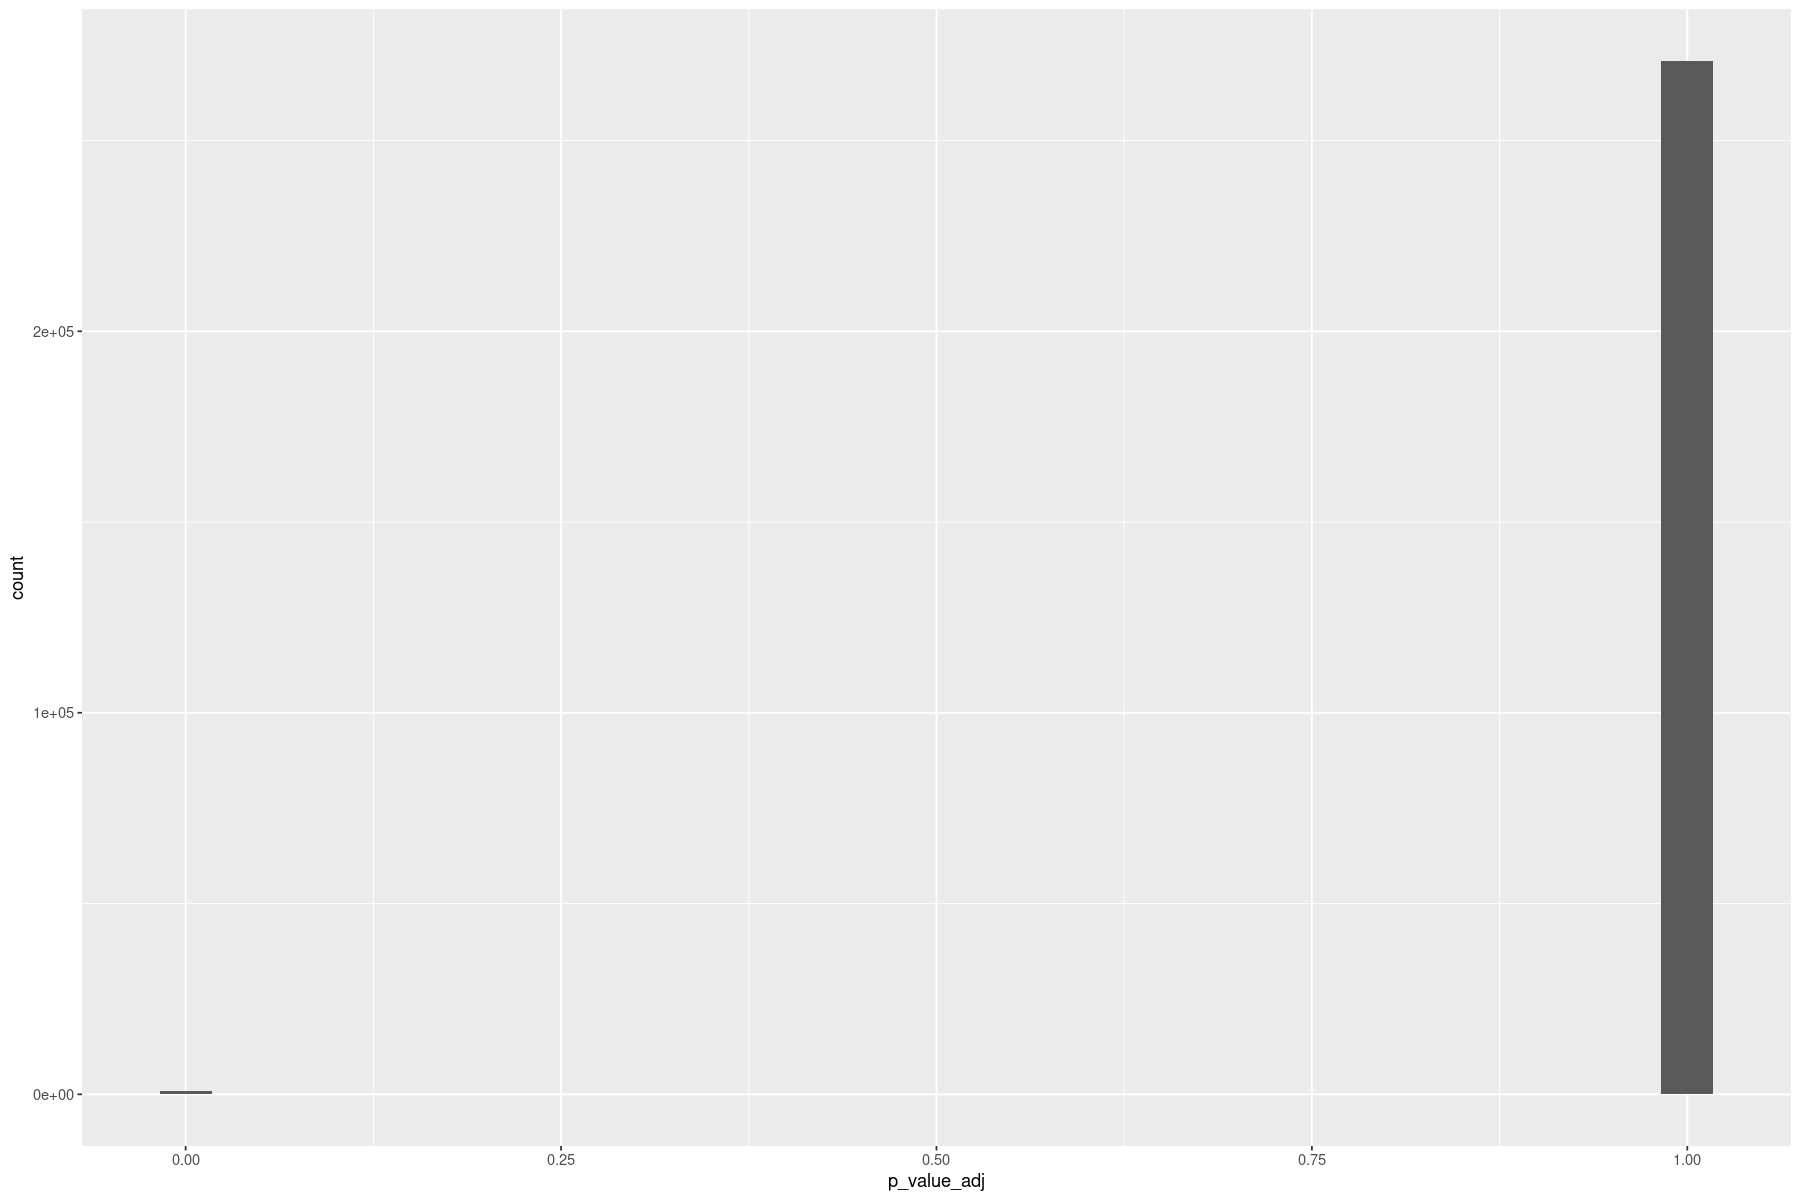

In [32]:
ggplot(z_comp, aes(x = p_value_adj)) +
    geom_histogram()
